In [189]:
import functions as fn
import matplotlib.pyplot as plt
import numpy as np
import time
import matplotlib.gridspec as gridspec

In [190]:
#Parameters
L = 1 #Length of domain
u_l = 0 #Left Dirichlet BC
u_r = 0 #Right Dirichlet BC
t_end = 0.5 

For the 1D Laplace equation with Dirichlet–Dirichlet boundary conditions, the exact solution is linear and is therefore represented exactly by the spectral element basis for any polynomial order $P \ge 1$. As a result, the numerical solution exhibits no observable spatial discretization error, and a traditional mesh refinement study is not informative. 
For this reason, spatial convergence is explored using the wave equation implemented in this work. For spatial convergence, two types of convergences are explored. First, an h-type refinement is done on the 1D mesh. This includes fixing the polynomial order of the basis functions and changing the number of elements over the domain. Next, a p-type refinement is executed.  p-type convergence studies fix the element number and vary the polynomial order of the basis functions. Like previously mentioned, h-type studies expect convergence on the order of $O(P+1)$ convergence while p-type expects spectral convergence.

In [191]:
def wave_solution(P,ne,L,u_l,u_r,t_end,dt):
    #Constructing Basis Functions
    roots, weights, zeta_c, bf = fn.Lagrange_basis_functions(P)

    #Constructing Mesh
    dx, x, elements, nodes_total, free_nodes = fn.Mesh_1D_DD(ne,L,roots)

    #Constructing Derivative Matrix
    D_matrix = fn.Lagrange_Derivative_Matrix(P,roots)

    #Constructing Stiffness Matrix
    K_matrix = fn.Stiffness_Matrix(P,D_matrix,weights,dx)
    K_global, K_global_free_nodes = fn.Global_Sum(P,K_matrix,ne,free_nodes)

    #Constructing Mass Matrix
    M_matrix = fn.Mass_Matrix(P,weights,dx)
    M_global, M_global_free_nodes = fn.Global_Sum(P,M_matrix,ne,free_nodes)

    #Constructing Load Vector
    F = fn.load_vec(K_global,u_l,u_r)

    #Timestepping
    num_t = int(np.round(t_end / dt)) + 1
    dt = t_end / (num_t - 1)
    t = np.arange(num_t) * dt
    len_t = len(t)
    
    Nx = len(nodes_total)
    u = np.zeros((num_t,Nx))
    u_init = np.sin(np.pi*nodes_total)
    u[0,:] = u_init

    u0 = u[0,1:-1].copy()
    v0 = np.zeros_like(u0)
    a0 = np.linalg.solve(M_global_free_nodes, -K_global_free_nodes @ u0)
    u[1,1:-1] = u0 + dt*v0 + 0.5*dt**2*a0

    u[:,0] = u_l
    u[:,-1] = u_r

    M_inv = 1/np.diag(M_global_free_nodes)
    for n in range(1,len_t-1):
        a = -K_global_free_nodes @ u[n,1:-1] 
        b = M_inv * a
        u[n+1,1:-1] = dt**2*b + 2*u[n,1:-1] - u[n-1,1:-1]

    #Exact
    u_exact = np.zeros((num_t,Nx))

    for i in range(len_t):
        for j in range(Nx):
            u_exact[i,j] = np.cos(np.pi * t[i])*np.sin(np.pi * nodes_total[j])
    
    return weights, dx, nodes_total, u, u_exact

def error_plot(hs,Es,axis=0):
    logx = np.log10(hs)
    logy = np.log10(Es)

    slope, intercept = np.polyfit(logx, logy, 1)

    print(f'Slope of dx convergence plot = {slope}')
    x_fit = np.linspace(hs[0], hs[-1], 10)
    y_fit = 10**(intercept) * x_fit**slope

    plt.loglog(hs, Es, color = 'black', marker='o', linewidth = 2)
    plt.loglog(x_fit, y_fit, '--', color = 'red', label = f'Slope = {round(slope,3)}')
    plt.ylabel('L2 Error', fontsize = 28)
    if axis == 0:
        plt.xlabel(r'$\Delta h$', fontsize = 28)
    if axis == 1:
        plt.xlabel(r'$\Delta t$', fontsize = 28)
    plt.xticks(fontsize = 20)
    plt.yticks(fontsize = 20)
    plt.legend(fontsize = 24)
    plt.grid()
    plt.show()

def error_plot_p(Ps, Es):
    Ps = np.asarray(Ps, dtype=float)
    Es = np.asarray(Es, dtype=float)

    logy = np.log10(Es)
    a, b = np.polyfit(Ps, logy, 1)

    # Smooth fit curve
    P_fit = np.linspace(Ps.min(), Ps.max(), 200)
    E_fit = 10**(a * P_fit + b)

    plt.semilogy(Ps, Es, color='black', marker='o', linewidth=2, label='Error')
    plt.ylabel('L2 Error', fontsize=28)
    plt.xlabel(r'Polynomial order $P$', fontsize=28)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    #plt.legend(fontsize=20)
    plt.grid(True, which='both')
    plt.show()



First, for the h-type study, the polynomial order is fixed at $P=5$ and $\Delta t = 1e-5$. The number of elements are set to $N_e = [1,2,3,4]$. The figure below shows the spatial convergence of the SEM for the 1D wave equation. The figure shows near $O(P+1)$ for this case.

finished
finished
finished
finished
Slope of dx convergence plot = 5.456375723855095


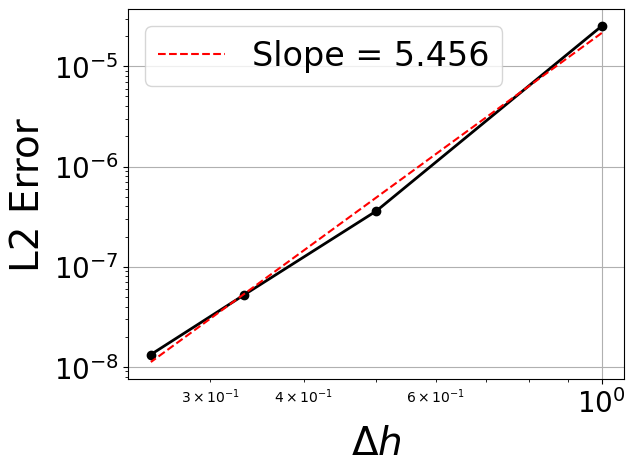

In [192]:
#H-type
ne_test = [1, 2, 3, 4]

P_ne = 5
dt_ne = 1e-5
dh = []
error = []
times_ne = []
for item in ne_test:
    start_time = time.perf_counter()
    w, dx, x, u, u_exact = wave_solution(P_ne,item,L,u_l,u_r,t_end,dt_ne)
    end_time = time.perf_counter()
    elapsed_time = end_time - start_time

    dh.append(dx)
    times_ne.append(elapsed_time)
    e = u[-1,:] - u_exact[-1,:]
    error_val  = np.linalg.norm(e, ord=2)
    error.append(error_val)
    print('finished')

error_plot(dh,error)

Finally, for the p-type study is done by fixing the number of $N_e = 2$ and $\Delta t = 1e-5$. Polynomial orders where varied from $P = [3,5,7,9]$ and the L2 errors were computed. The figure below shows the results of the p-type spatial study. The figure shows a spectral order of convergence in the solution as the polynomial order is increased.

finished
finished
finished
finished


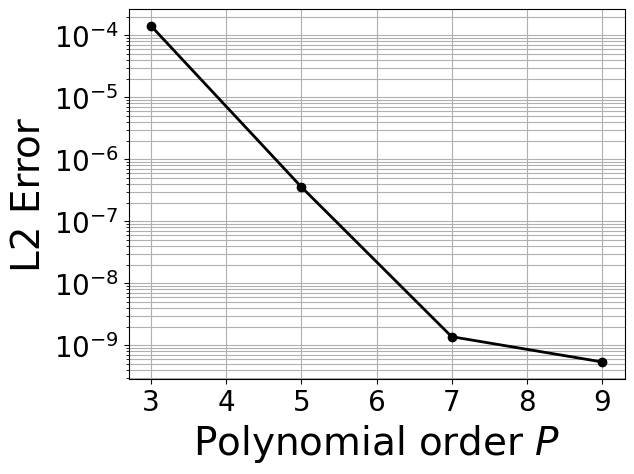

In [193]:
#P-type
P_test = [3,5,7,9]

error_p = []
times_p = []
ne_p = 2
dt_p = 1e-5
for item in P_test:
    start_time = time.perf_counter()
    w, dx, x, u, u_exact = wave_solution(item,ne_p,L,u_l,u_r,t_end,dt_p)
    end_time = time.perf_counter()

    elapsed_time = end_time - start_time

    e = u[-1,:] - u_exact[-1,:]
    error_val = np.linalg.norm(e, ord=2)
    error_p.append(error_val)
    times_p.append(elapsed_time)
    print('finished')

error_plot_p(P_test,error_p)

The temperoral convergence of the 1D wave equation was done by fixing the number of elements and polynomial order in the domain and varying the time step size. For this work, the number of elements was fixed to $N_e = 4$ and the polynomial order was fixed to $P = 7$. Similar to the small time step size in the spatial convergence section, the small grid size minimizes the spatial error in this study. The figure below shows the L2 error vs time step size for the 1D wave equation and parameters stated in this section. $\Delta t$ was varied to $[5e-3, 1e-3,5e-4, 1e-4]$  The figure shows 2nd order convergence which is expected with the central differencing scheme used in this work.

finished
finished
finished
finished
Slope of dx convergence plot = 1.999703840579379


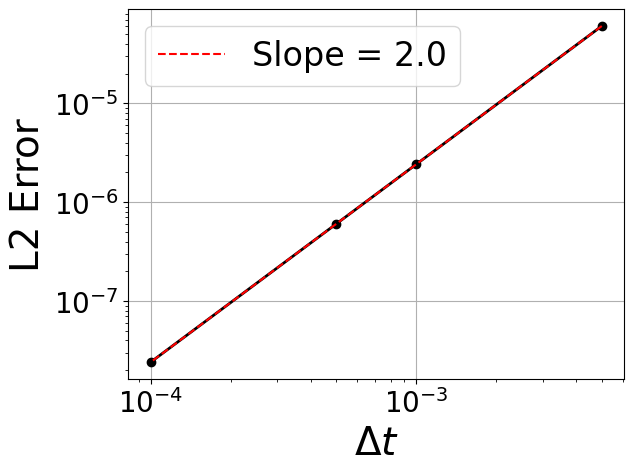

In [194]:
#Time Study
dt_test = [5e-3, 1e-3, 5e-4, 1e-4]

ne_dt = 4
P_dt = 7
error_t = []
times_t = []
for item in dt_test:
    start_time = time.perf_counter()
    w, dx, x, u, u_exact = wave_solution(P_dt,ne_dt,L,u_l,u_r,t_end,item)
    end_time = time.perf_counter()

    elapsed_time = end_time - start_time
    e = u[-1,:] - u_exact[-1,:]
    error_val = np.linalg.norm(e, ord=2)
    error_t.append(error_val)
    times_t.append(elapsed_time)
    print('finished')

error_plot(dt_test,error_t,axis=1)

In addition to the temporal and spatial convergence analysis, a runtime study was performed for this work. Ever simulation that was run to collect data for the convergence study also collected runtime data and plotted in the figure below. As expected, The simulation runtime increased with decreasing the spatial and temporal step size. Furthermore, increasing the polynomial order increased the simulation runtime. From the initial study, it can be concluded for the 1D wave equation problem, that varying $\Delta t$, $\Delta x$, or $P$ has a similar impact on the runtime for the simulation.

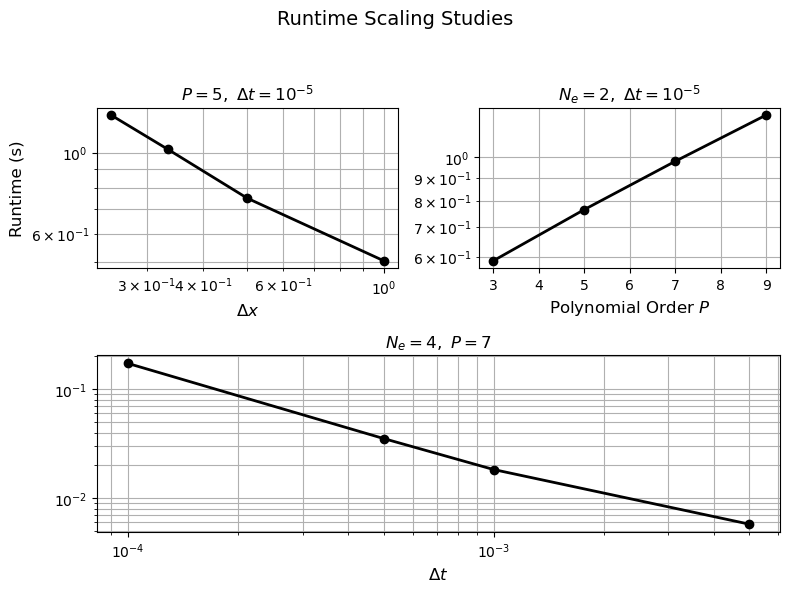

In [195]:
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1.1])

ax0 = fig.add_subplot(gs[0, 0])
ax0.loglog(dh, times_ne, marker='o', linewidth=2, color='black')
ax0.set_xlabel(r'$\Delta x$', fontsize=12)
ax0.set_ylabel('Runtime (s)', fontsize=12)
ax0.set_title(r'$P=5,\ \Delta t=10^{-5}$')
ax0.grid(True, which='both')

ax1 = fig.add_subplot(gs[0, 1])
ax1.semilogy(P_test, times_p, marker='o', linewidth=2, color='black')
ax1.set_xlabel('Polynomial Order $P$', fontsize=12)
ax1.set_title(r'$N_e=2,\ \Delta t=10^{-5}$')
ax1.grid(True, which='both')

ax2 = fig.add_subplot(gs[1, :])
ax2.loglog(dt_test, times_t, marker='o', linewidth=2, color='black')
ax2.set_xlabel(r'$\Delta t$', fontsize=12)
ax2.set_title(r'$N_e=4,\ P=7$')
ax2.grid(True, which='both')

fig.suptitle('Runtime Scaling Studies', fontsize=14)
fig.tight_layout(rect=[0, 0, 1, 0.94])
plt.show()